<a href="https://colab.research.google.com/github/Rum1ne/milo/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
import pandas as pd
from google.colab import drive
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, Binarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn import utils
from lightgbm import LGBMRegressor
drive.mount('/content/drive')
pd.options.mode.chained_assignment = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies.csv', delimiter = ',')
df = df.sort_values('release_date')
df.head(1)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
39977,315946,Passage of Venus,Documentary,fr,Photo sequence of the rare transit of Venus ov...,4.599,NaN,1874-12-09,0.0,0.0,1.0,Released,NaN,6.2,80.0,NaN,silent film-astronomy-venus the planet-19th ce...,/XWPDZzK7N2WQcejI8W96IxZEeP.jpg,/6vYffq6NoneNmNPp6IsobnnlrHS.jpg,194079-426903-16463-16464-159897-34372-798558-...


In [ ]:
df.index = [i for i in range(df.shape[0])]

df = df.iloc[400000:]
df = df.dropna(subset = ['id', 'title', 'genres', 'original_language', 'popularity', 'budget', 'revenue', 'vote_average', 'vote_count', 'credits'])
df = df[['title', 'genres', 'original_language', 'popularity', 'budget', 'revenue', 'vote_average', 'vote_count', 'credits']]
df.index = [i for i in range(df.shape[0])]

df[['budget', 'revenue']] = df[['budget', 'revenue']].astype(int)
df = df.query('revenue!=0')
df = df.query('budget!=0')
df.index = [i for i in range(df.shape[0])]

for i in range(len(df['genres'])):
  df['genres'][i] = df['genres'][i].split('-')
for i in range(len(df['credits'])):
  df['credits'][i] = df['credits'][i].split('-')[:5]
df

,title,genres,original_language,popularity,budget,revenue,vote_average,vote_count,credits
0,Trance,"[Thriller, Crime, Drama, Mystery]",en,10.593,20000000,24261569,6.6,1954.0,"[James McAvoy, Vincent Cassel, Rosario Dawson,..."
1,G.I. Joe: Retaliation,"[Science Fiction, Adventure, Action, Thriller]",en,27.013,130000000,371876278,5.6,5049.0,"[Dwayne Johnson, Bruce Willis, Jonathan Pryce,..."
2,Finding Home,"[Drama, Family]",en,0.600,10000,1000,10.0,1.0,"[Michael Empson, Michael Gordon, Victoria Mull..."
3,Pee Mak,"[Comedy, Romance, Horror]",th,10.234,1800000,33000000,7.2,101.0,"[Mario Maurer, Davika Hoorne, Nattapong Chartp..."
4,We Are the Nobles,[Comedy],es,24.885,2000000,26433651,7.9,436.0,"[Gonzalo Vega, Luis Gerardo Méndez, Karla Souz..."
...,...,...,...,...,...,...,...,...,...
3606,Psique,[Horror],es,0.600,500,1500,10.0,1.0,[Álex Juárez]
3607,A Wonderful Life,[Comedy],en,0.600,1000,100,10.0,1.0,[Thomas Rock]
3608,Rightways Down,"[Crime, Drama, Thriller]",en,0.600,4000,7800,0.0,0.0,[J. Adam Young]
3609,What's There to Say?,"[Drama, Documentary]",en,0.600,50,50,10.0,1.0,"[Rob Gordon, Alli Gordon, Anakeesta Ironwood]"


In [ ]:
langs = []
for i in range(len(df['original_language'])):
  if df['original_language'][i] not in langs:
    langs.append(df['original_language'][i])

counts = [0] * len(langs)
for i in range(len(df['original_language'])):
  for j in range(len(langs)):
    if df['original_language'][i] == langs[j]:
      counts[j] +=1

langs_count = []
for i in range(len(langs)):
  langs_count.append([i, langs[i], counts[i]])

m = []
for i in range(len(df['original_language'])):
  for j in langs_count:
    if j[2] < 20 and df['original_language'][i] == j[1]:
      m.append(i)

for i in m:
  df = df.drop(i)

df.index = [i for i in range(df.shape[0])]

genres = []
for i in range(len(df['genres'])):
  for j in df['genres'][i]:
    if j not in genres:
      genres.append(j)

counts2 = [0] * len(genres)
for i in range(len(df['genres'])):
  for j in range(len(df['genres'][i])):
    for k in range(len(genres)):
      if df['genres'][i][j] == genres[k]:
        counts2[k] +=1

genre_count = []
for i in range(len(genres)):
  genre_count.append([i, genres[i], counts2[i]])


m = []
for i in range(len(df['genres'])):
  for j in range(len(df['genres'][i])):
    for k in genre_count:
      if k[2] < 100 and df['genres'][i][j] == k[1]:
        m.append(i)

for i in m:
  df = df.drop(i)

df.index = [i for i in range(df.shape[0])]
print(langs_count)
print(genre_count)

[[0, 'en', 2313], [1, 'th', 7], [2, 'es', 156], [3, 'hi', 143], [4, 'ml', 70], [5, 'ru', 115], [6, 'fr', 127], [7, 'ur', 30], [8, 'ta', 38], [9, 'te', 48], [10, 'fa', 67], [11, 'it', 32], [12, 'tl', 8], [13, 'sv', 6], [14, 'pt', 52], [15, 'he', 16], [16, 'kn', 19], [17, 'ja', 23], [18, 'ko', 43], [19, 'bs', 1], [20, 'bn', 21], [21, 'zh', 45], [22, 'de', 48], [23, 'da', 11], [24, 'sk', 2], [25, 'pl', 10], [26, 'nl', 5], [27, 'vi', 9], [28, 'ka', 2], [29, 'id', 9], [30, 'ne', 7], [31, 'ar', 12], [32, 'cn', 7], [33, 'tr', 19], [34, 'hu', 5], [35, 'no', 12], [36, 'fi', 8], [37, 'uk', 6], [38, 'mr', 5], [39, 'ro', 9], [40, 'dv', 1], [41, 'pa', 11], [42, 'ms', 5], [43, 'bg', 1], [44, 'sq', 1], [45, 'et', 1], [46, 'si', 1], [47, 'mn', 1], [48, 'gu', 4], [49, 'lv', 1], [50, 'dz', 1], [51, 'lg', 1], [52, 'ca', 2], [53, 'cs', 2], [54, 'km', 1], [55, 'lt', 4], [56, 'gl', 2], [57, 'nb', 3], [58, 'jv', 1], [59, 'xx', 1]]
[[0, 'Thriller', 727], [1, 'Crime', 388], [2, 'Drama', 1564], [3, 'Mystery', 2

<BarContainer object of 19 artists>

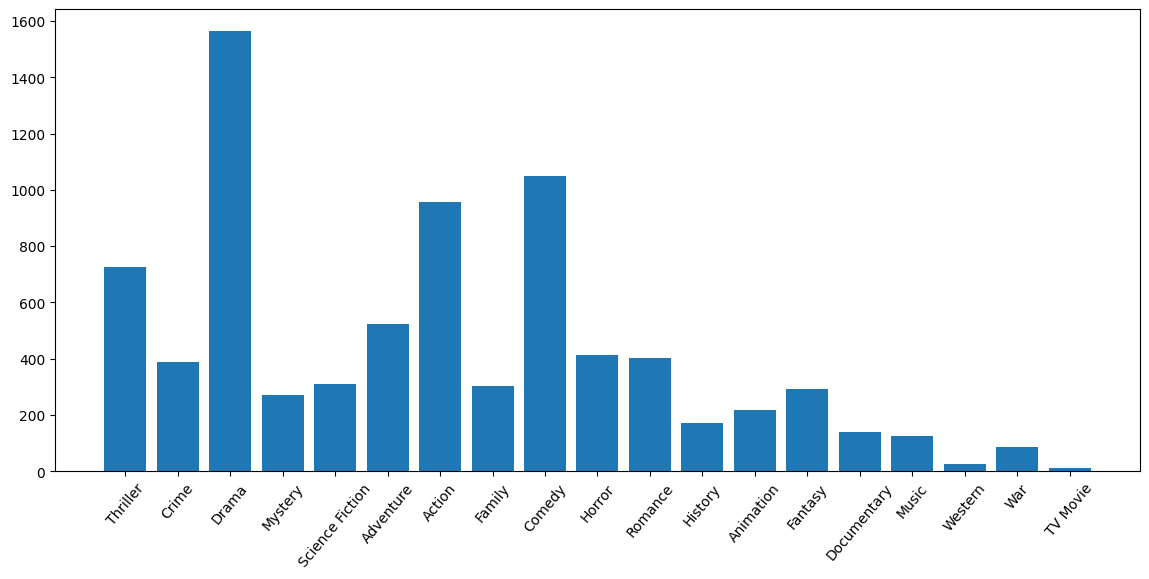

In [ ]:
plt.figure(figsize=(14, 6))
plt.xticks(np.arange(len(genres)), genres, rotation=50)
plt.bar(np.arange(len(genres)), counts2)

<BarContainer object of 60 artists>

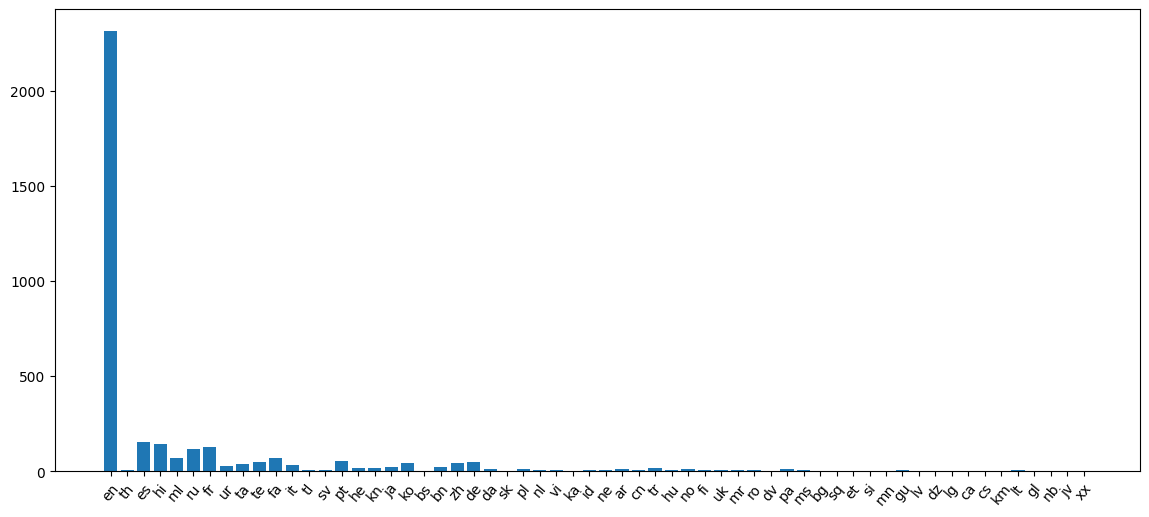

In [ ]:
plt.figure(figsize=(14, 6))
plt.xticks(np.arange(len(langs)), langs, rotation=50)
plt.bar(np.arange(len(langs)), counts)

In [ ]:
for i in range(len(df['genres'])):
  for j in range(len(df['genres'][i])):
    for k in genre_count:
      if df['genres'][i][j] == k[1]:
        df['genres'][i][j] = k[0]

for i in range(len(df['genres'])):
  summ = 0
  count = 0
  for j in range(len(df['genres'][i])):
    summ += df['genres'][i][j]
    count += 1
  df['genres'][i] = round(summ/count, 2)

for i in range(len(df['original_language'])):
  for j in langs_count:
    if df['original_language'][i] == j[1]:
      df['original_language'][i] = j[0]

df

,title,genres,original_language,popularity,budget,revenue,vote_average,vote_count,credits
0,Trance,1.5,0,10.593,20000000,24261569,6.6,1954.0,"[James McAvoy, Vincent Cassel, Rosario Dawson,..."
1,G.I. Joe: Retaliation,3.75,0,27.013,130000000,371876278,5.6,5049.0,"[Dwayne Johnson, Bruce Willis, Jonathan Pryce,..."
2,Finding Home,4.5,0,0.600,10000,1000,10.0,1.0,"[Michael Empson, Michael Gordon, Victoria Mull..."
3,We Are the Nobles,8.0,2,24.885,2000000,26433651,7.9,436.0,"[Gonzalo Vega, Luis Gerardo Méndez, Karla Souz..."
4,Himmatwala,5.33,3,0.600,9500000,6800000,3.4,36.0,"[Ajay Devgn, Tamannaah Bhatia, Mahesh Manjreka..."
...,...,...,...,...,...,...,...,...,...
3241,Psique,9.0,2,0.600,500,1500,10.0,1.0,[Álex Juárez]
3242,A Wonderful Life,8.0,0,0.600,1000,100,10.0,1.0,[Thomas Rock]
3243,Rightways Down,1.0,0,0.600,4000,7800,0.0,0.0,[J. Adam Young]
3244,What's There to Say?,8.0,0,0.600,50,50,10.0,1.0,"[Rob Gordon, Alli Gordon, Anakeesta Ironwood]"


In [ ]:
df['vote_count'] = df['vote_count'].astype(int)
df = df[df.vote_count > 30]
df.index = [i for i in range(df.shape[0])]

for i in range(len(df['credits'])):
  s = ''
  for j in range(len(df['credits'][i])):
    s = s + df['credits'][i][j] + ', '
  df['credits'][i] = s

df['vote_count'] = df['vote_count'].tolist()
df['revenue'] = df['revenue'].tolist()
df['budget'] = df['budget'].tolist()
df

,title,genres,original_language,popularity,budget,revenue,vote_average,vote_count,credits
0,Trance,1.5,0,10.593,20000000,24261569,6.600,1954,"James McAvoy, Vincent Cassel, Rosario Dawson, ..."
1,G.I. Joe: Retaliation,3.75,0,27.013,130000000,371876278,5.600,5049,"Dwayne Johnson, Bruce Willis, Jonathan Pryce, ..."
2,We Are the Nobles,8.0,2,24.885,2000000,26433651,7.900,436,"Gonzalo Vega, Luis Gerardo Méndez, Karla Souza..."
3,Himmatwala,5.33,3,0.600,9500000,6800000,3.400,36,"Ajay Devgn, Tamannaah Bhatia, Mahesh Manjrekar..."
4,Adore,2.0,0,24.107,16000000,1575749,6.100,861,"Naomi Watts, Robin Wright, Xavier Samuel, Jame..."
...,...,...,...,...,...,...,...,...,...
1950,Five Nights at Freddy's,6.0,0,1436.818,20000000,260450582,7.999,2202,"Josh Hutcherson, Piper Rubio, Elizabeth Lail, ..."
1951,Godzilla Minus One,6.33,17,348.423,13000000,74000000,8.095,184,"Ryunosuke Kamiki, Hidetaka Yoshioka, Minami Ha..."
1952,The Hunger Games: The Ballad of Songbirds & Sn...,4.0,0,1329.764,100000000,322300000,7.300,1211,"Tom Blyth, Rachel Zegler, Peter Dinklage, Jaso..."
1953,Saltburn,3.33,0,559.924,13000000,19313341,7.171,674,"Barry Keoghan, Jacob Elordi, Rosamund Pike, Ri..."


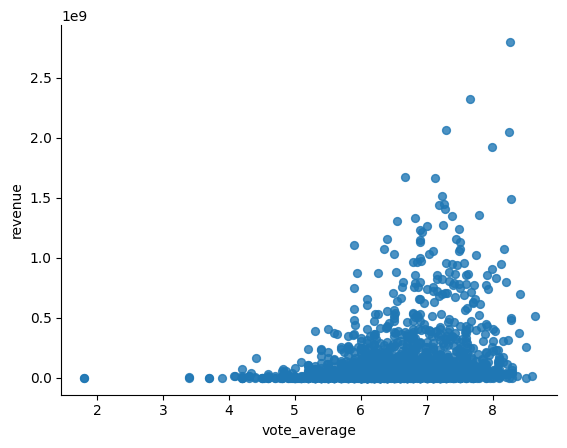

In [ ]:
df.plot(kind='scatter', x='vote_average', y='revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

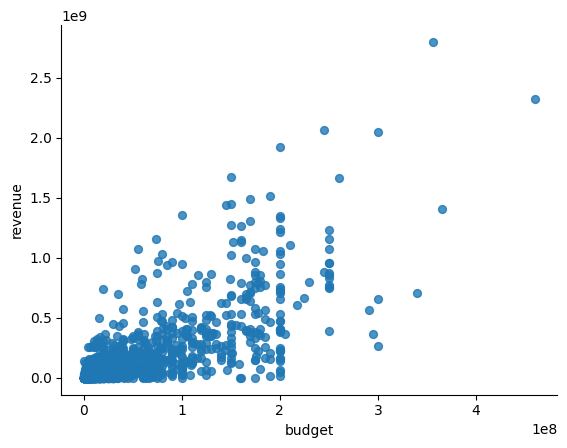

In [ ]:
df.plot(kind='scatter', x='budget', y='revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

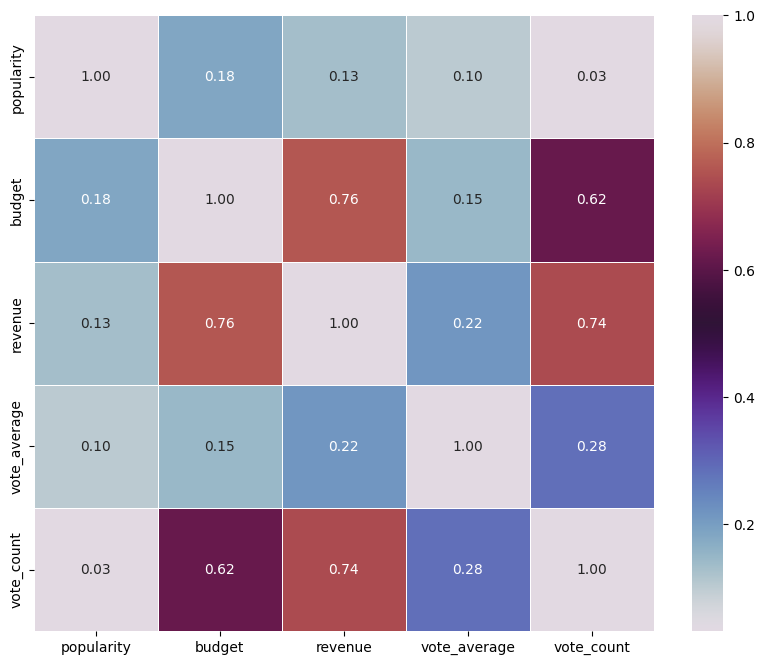

In [ ]:
df_ = df[['popularity', 'budget', 'revenue', 'vote_average', 'vote_count']].astype(int)
corr_matrix = df_.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'twilight', fmt = '.2f', linewidths = 0.5)
plt.show()

In [55]:
x = df[['vote_count', 'budget']]
y = df[['revenue']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = LGBMRegressor()
model.fit(x_train, y_train)
r2_score(y_test.values.tolist(), model.predict(x_test).tolist())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 1564, number of used features: 2
[LightGBM] [Info] Start training from score 118071638.547315


0.7768084764270751